# Old preprocessing stuff

In [1]:
from utils import load_house_prices_data

train_origin_df = load_house_prices_data('train')
train_features = train_origin_df.drop('SalePrice', axis='columns')

In [2]:
from utils import calc_numeric_feature_correlation

numeric_correlations = calc_numeric_feature_correlation(train_features)
threshold = 0.7
highly_correlated_numeric_features = [t for t in numeric_correlations if t[2] >= threshold]

print(highly_correlated_numeric_features)

[('YearBuilt', 'GarageYrBlt', 0.826), ('TotalBsmtSF', '1stFlrSF', 0.82), ('GrLivArea', 'TotRmsAbvGrd', 0.825), ('GarageCars', 'GarageArea', 0.882)]


In [3]:
#features to drop due to high correlation with another feature (one from each pair):
# we drop features that are not common to all samples (e.g., all buildings must have YearBuilt but not necessarily GarageYrBlt)
high_correlated_features_to_drop = ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars']

In [4]:
# Object features that show low correlation to target (by indirect impression):
cat_cols_uncor_w_target = ['LotShape', 'LandContour', 'LotConfig',
                           'LandSlope', 'Condition2', 'RoofMatl', 'BsmtExposure',
                           'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                           'Functional', 'Fence', 'MiscFeature'
                           ]

In [5]:
#numerical features to drop due to high imbalance of the data:
drop_imbalanced = ['Heating', 'Alley', 'Street', 'Utilities']


In [6]:
# filtering the data frame according to selected features to drop:
filtered_df = train_origin_df.drop(high_correlated_features_to_drop, axis=1)
filtered_df = filtered_df.drop(cat_cols_uncor_w_target, axis=1)
filtered_df.drop(drop_imbalanced, axis=1, inplace=True)

In [7]:
from preprocessing import preprocess

# only 7 samples with pool, but might be important, so:
# we create new *binary* feature 'HavePool' and drop 'PoolQC' 'PoolArea'

# And replacing missing values in 'LotFrontage' with mean values:

filtered_preprocessed_df = preprocess(filtered_df)

# New - Feature Engineering

## Handling Ordinal Features

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [11]:
# Converting ordinal categories into numbers (0 is worst)
# Not including 'PoolQC' (which was handled elsewhere)
# Returns the same df but with ordinal features converted to ints

from sklearn.preprocessing import OrdinalEncoder

ordinal_df = filtered_preprocessed_df.copy() # change to the correct df (after handling missing values)

# Grouping features by unique values
common_convert_to_ordinal1 = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']
common_categories1 = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

common_convert_to_ordinal2 = ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']
common_categories2 = ['No', 'Po', 'Fa', 'TA', 'Gd', 'Ex'] # 'No' was NA before handling missing values

uncommon_convert_to_ordinal = ['LotShape', 'Utilities', 'LandSlope', 'BsmtExposure', 'Functional', 'GarageFinish']
uncommon_categories = [['IR3', 'IR2', 'IR1', 'Reg'], #LotShape
                     ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], #Utilities
                     ['Sev', 'Mod', 'Gtl'], #LandSlope
                     ['No', 'Mn', 'Av', 'Gd'], #BsmtExposure #PROBLEM: handling missing values joins two categories (NA + 'No')
                     ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], #Functional
                     ['No', 'Unf', 'RFn', 'Fin'] # GarageFinish # 'No was NA before handling missing values
                     ]

# Converting features to ints
ord_enc1 = OrdinalEncoder(categories=[common_categories1] * len(common_convert_to_ordinal1))
ord_enc2 = OrdinalEncoder(categories=[common_categories2] * len(common_convert_to_ordinal2))
ord_enc3 = OrdinalEncoder(categories=uncommon_categories)

ordinal_df[common_convert_to_ordinal1] = ord_enc1.fit_transform(ordinal_df[common_convert_to_ordinal1])
ordinal_df[common_convert_to_ordinal2] = ord_enc2.fit_transform(ordinal_df[common_convert_to_ordinal2])
ordinal_df[uncommon_convert_to_ordinal] = ord_enc3.fit_transform(ordinal_df[uncommon_convert_to_ordinal])

ValueError: Found unknown categories ['None'] in column 0 during fit

## Handling area features

### NOTE on total area

In [ ]:
# In the data, '1stFlrSF' + '2ndFlrSF' = 'GrLivArea'
# We dropped '1stFlrSF' due to high correlation with 'GrLivArea'
# Consider dropping also '2ndFlrSF' (being left with total area size only)

### Porches area

In [14]:
# Joining porches area sizes (two types)
# Returns the same df but with two new features for porches area instead of 5

close_porches = ['EnclosedPorch', '3SsnPorch', 'ScreenPorch']
open_porches = ['OpenPorchSF', 'WoodDeckSF']

def join_areas(cols):
    return cols.sum()

df_joined_porches = filtered_preprocessed_df.copy() # change to the correct df (after handling missing values)

df_joined_porches['TotClosePorchSF'] = df_joined_porches[close_porches].apply(join_areas, axis=1)
df_joined_porches['TotOpenPorchSF'] = df_joined_porches[open_porches].apply(join_areas, axis=1)
df_joined_porches.drop(columns=close_porches + open_porches, inplace=True)

## Handling neighborhoods

### Connection between neighborhood and total area size

Total area size (as depicted by 'GrLivArea') varies significantly between neighborhoods. It's plausible that less dense neighborhoods, for example, have houses with larger area. Therefore, houses of significantly large areas (with respect to other properties in the same neighborhood) are plausibly more expensive.

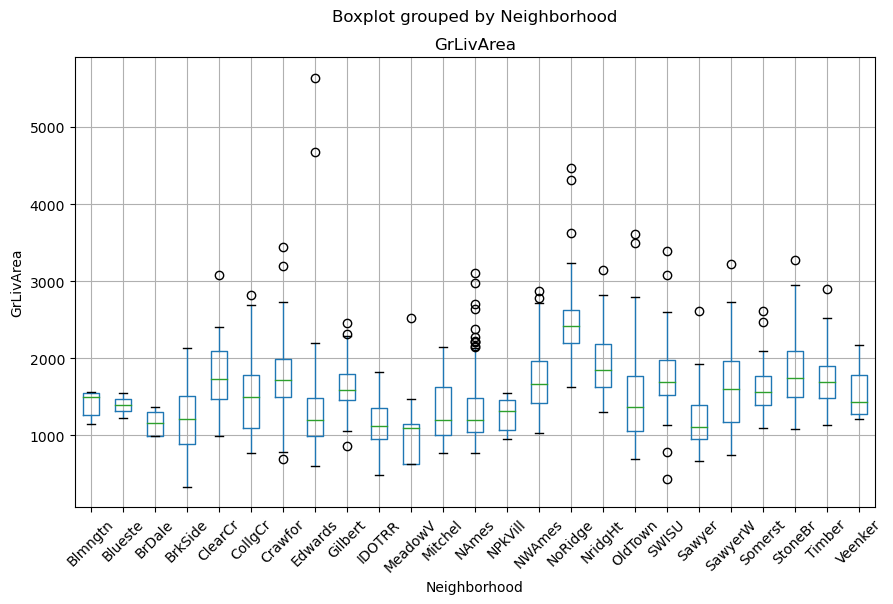

In [15]:
from matplotlib import pyplot as plt
train_origin_df.boxplot(column='GrLivArea', by='Neighborhood', figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('GrLivArea')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Creating features that capture relation between price and total area per neighborhood
# Adds the two feature to the data (without dropping 'GrLivArea')

norm_area_df = train_origin_df.copy() # change to the correct df (after handling missing values)

neighborhood_stats = norm_area_df.groupby('Neighborhood')['GrLivArea'].agg(['median', lambda x: np.quantile(x, 0.75)])
neighborhood_stats.columns = ['50%', '75%']
neighborhood_stats.reset_index(inplace=True)

norm_area_df = pd.merge(norm_area_df, neighborhood_stats, on='Neighborhood', how='left')

norm_area_df['SizeRelativeToMedian'] = norm_area_df['GrLivArea'] / norm_area_df['50%']
norm_area_df['IsInTopQuartile'] = (norm_area_df['GrLivArea'] > norm_area_df['75%']).astype(int)

In [17]:
norm_area_df['SizeRelativeToMedian'].corr(norm_area_df['SalePrice'])

0.3671783782429684

In [18]:
norm_area_df['IsInTopQuartile'].corr(norm_area_df['SalePrice'])

0.3228725203409257

### Sale prices varies significantly between neighborhoods. It might be beneficial to group similar neighborhoods to reduce data complexity without loosing significant information.

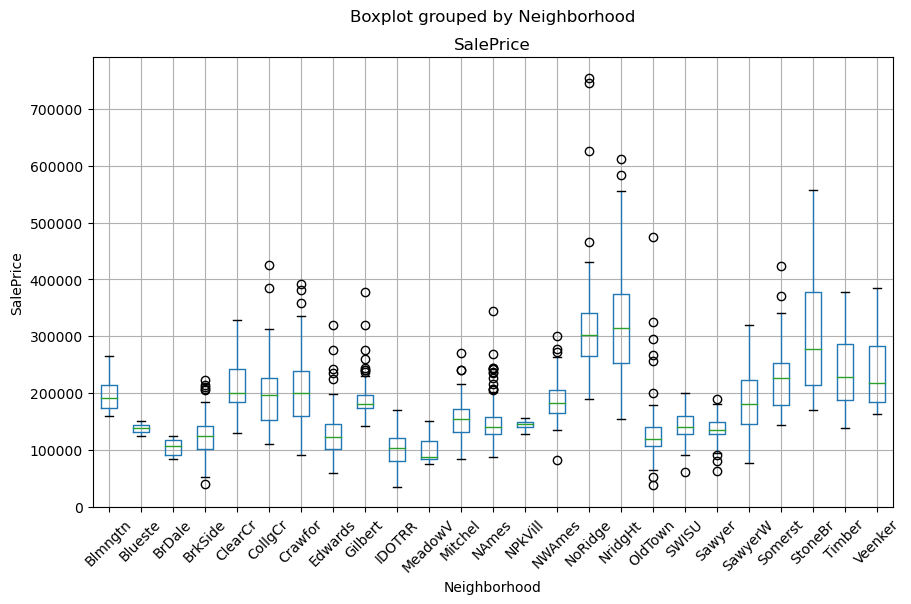

In [19]:
from matplotlib import pyplot as plt
train_origin_df.boxplot(column='SalePrice', by='Neighborhood', figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Calculate median SalePrice for each neighborhood
# Returns teh same df but with a new feature 'NeibLevel' that should replace 'Neighborhood' (not dropped in this code)

nbr_levels_df = train_origin_df.copy() # change to the correct df (after handling missing values)

neighborhood_medians = nbr_levels_df.groupby('Neighborhood')['SalePrice'].median().reset_index(name='MedianSalePrice')

percentile_25 = neighborhood_medians['MedianSalePrice'].quantile(0.25)
percentile_75 = neighborhood_medians['MedianSalePrice'].quantile(0.75)

def classify_neighborhood(price):
    if price <= percentile_25:
        return 'Low'
    elif price >= percentile_75:
        return 'High'
    else:
        return 'Medium'

neighborhood_medians['NeibLevel'] = neighborhood_medians['MedianSalePrice'].apply(classify_neighborhood)

nbr_levels_df = pd.merge(nbr_levels_df, neighborhood_medians[['Neighborhood', 'NeibLevel']], on='Neighborhood', how='left')

### Overall condition per neighborhood

Similar to total area, overallcond may have notable effect on  the sale price when taking into account the neighborhood. Fot example, pricier neighborhoods may have houses in worse conditions (in absolute 1-10 scale), but then the better condition houses would be much expensive. This needs further research.

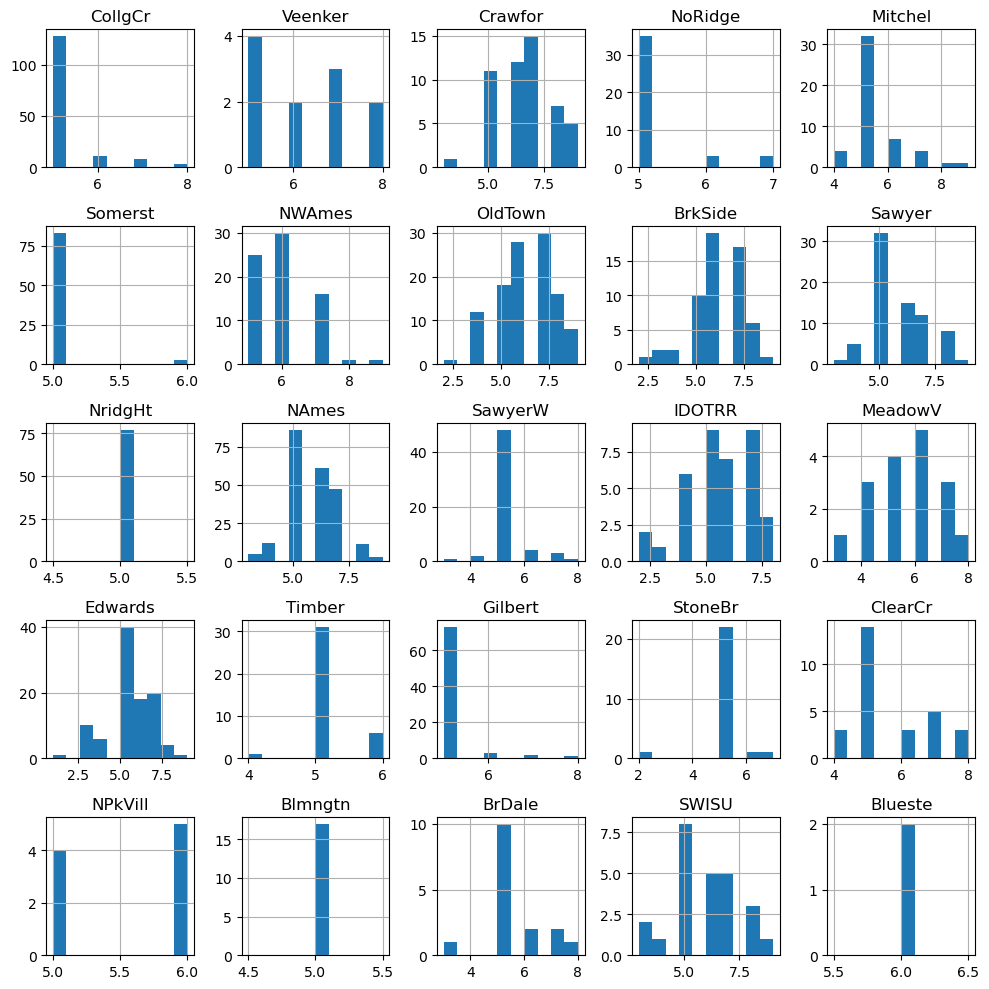

In [21]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))

for i, nbr in enumerate(train_origin_df['Neighborhood'].unique()):
    ax = axes[i // 5, i % 5]
    train_origin_df.loc[train_origin_df['Neighborhood'] == nbr, 'OverallCond'].hist(ax=ax)
    ax.set_title(nbr)

plt.tight_layout()
plt.show()

##Total area by MSZoning

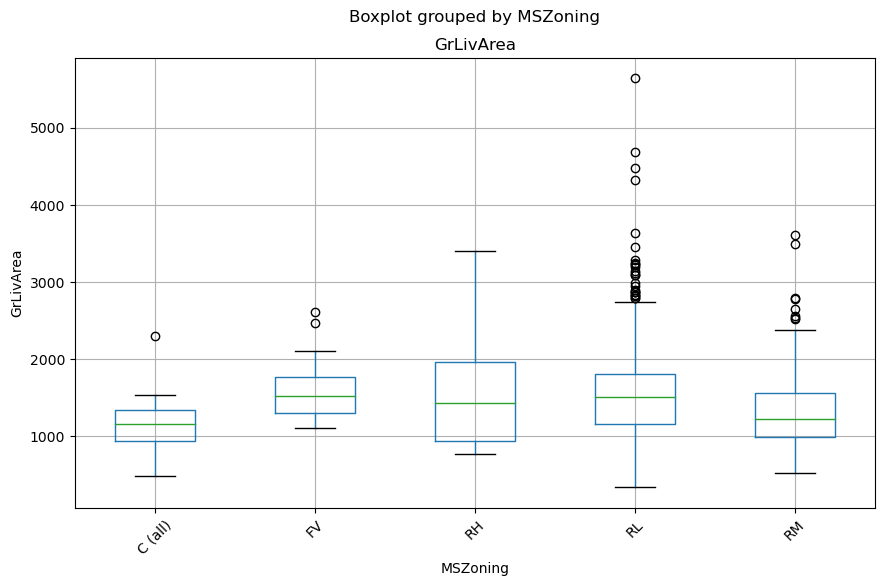

In [22]:
from matplotlib import pyplot as plt
train_origin_df.boxplot(column='GrLivArea', by='MSZoning', figsize=(10,6))
plt.xlabel('MSZoning')
plt.ylabel('GrLivArea')
plt.xticks(rotation=45)
plt.show()